In [10]:
import pandas as pd
from datetime import datetime
from datetime import timedelta
import numpy as np
import matplotlib.pyplot as plt
from tbats import TBATS, BATS
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

In [4]:
#read data
df = pd.read_csv(r'C:\Users\I539797\Documents\Thesis\Datasets\Formatted Datasets\formatted_amsterdam.csv', parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
df.head()

,NumericIndex,OriginMovementID,DestinationMovementID,MeanTravelTimeSeconds,RangeLowerBoundTravelTimeSeconds,RangeUpperBoundTravelTimeSeconds,DayOfWeek
Date,,,,,,,
2016-01-02,135599,30,164,375,324,433,Saturday
2016-01-02,135571,30,48,326,147,719,Saturday
2016-01-02,135570,30,47,676,444,1027,Saturday
2016-01-02,135569,30,46,691,436,1092,Saturday
2016-01-02,135568,30,45,1112,677,1825,Saturday


In [5]:
y = pd.DataFrame(df.groupby('Date')['MeanTravelTimeSeconds'].mean()[:-90])
y.head()

,MeanTravelTimeSeconds
Date,
2016-01-02,564.500000
2016-01-03,558.734694
2016-01-04,491.256410
2016-01-05,538.263158
2016-01-06,583.054054


In [13]:
train_end = datetime(2018, 12, 31)
test_end = datetime(2019, 12, 31)

train_data = y[:train_end]    # [:(len(y)-365)]
test_data = y[train_end + timedelta(days=1):test_end]

Text(0.5, 1.0, 'Time Series Data')

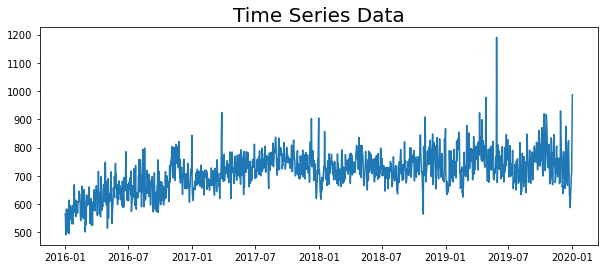

In [14]:
plt.figure(figsize=(10,4))
plt.plot(y)
plt.title('Time Series Data', fontsize=20)

In [30]:
y.loc[y.index[1090:1100]]

,MeanTravelTimeSeconds
Date,
2018-12-29,830.302752
2018-12-30,812.596491
2018-12-31,826.719626
2019-01-01,867.373913
2019-01-02,692.663043
2019-01-03,687.333333
2019-01-04,645.036145
2019-01-05,634.117021
2019-01-06,679.653465


## TBATS

In [31]:
predictions_rolling = pd.Series()
for end_date in test_data.index:
    train_data = y[:end_date - timedelta(days=1)]
    model = TBATS(seasonal_periods=(7, 365.2425))
    model_fit = model.fit(train_data)
    pred = model_fit.forecast(steps=1)
    pred = pd.Series(pred.astype('datetime64', copy=False))
    predictions_rolling.loc[end_date] = pred.loc[end_date]


# # Fit the model
# estimator = TBATS(seasonal_periods=(7, 30.5))
# model = estimator.fit(y_to_train)

# # Forecast 365 days ahead
# y_forecast = model.forecast(steps=365)

<ipython-input-31-4571cd40696d>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  predictions_rolling = pd.Series()


SystemError: <built-in function ensure_datetime64ns> returned a result with an error set

In [63]:
print(model.summary())

Use Box-Cox: False
Use trend: False
Use damped trend: False
Seasonal periods: [ 7.  30.5]
Seasonal harmonics [2 1]
ARMA errors (p, q): (2, 3)
Smoothing (Alpha): 0.062945
Seasonal Parameters (Gamma): [-1.05872761e-05  1.69382929e-06 -3.23830194e-07 -9.93230054e-06]
AR coefficients [-3.23830194e-07 -9.93230054e-06]
MA coefficients [0.2934698  0.09915563 0.05169149]
Seed vector [ 5.60553704e+02  6.65444851e+00  4.63907104e-01 -1.15765186e+01
 -3.65258617e+00  1.32866134e+00 -4.25553921e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]

AIC 15765.663218


In [64]:
#get the predictions and residuals
predictions = pd.Series(y_forecast, index=y_to_test.index)
residuals = y_to_test - predictions

Text(0, 0.5, 'Seconds')

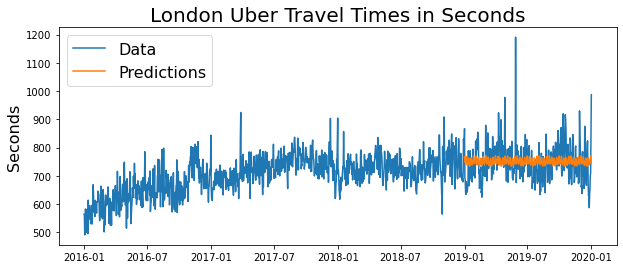

In [65]:
plt.figure(figsize=(10,4))

plt.plot(y)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('London Uber Travel Times in Seconds', fontsize=20)
plt.ylabel('Seconds', fontsize=16)
# for year in range(start_date.year,end_date.year):
#     plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [66]:
# Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_to_test, predictions): 
    y_to_test, predictions = np.array(y_to_test), np.array(predictions)
    return np.mean(np.abs((predictions - y_to_test)/y_to_test)) * 100

mean_absolute_percentage_error(y_to_test, predictions)

6.842403944647274

In [67]:
# Root Mean Square Error (RMSE)
def rmse(y_to_test, predictions):
    y_to_test, predictions = np.array(y_to_test), np.array(predictions)
    return np.sqrt(np.mean((predictions - y_to_test)**2))

rmse(y_to_test, predictions)

66.94372838360161

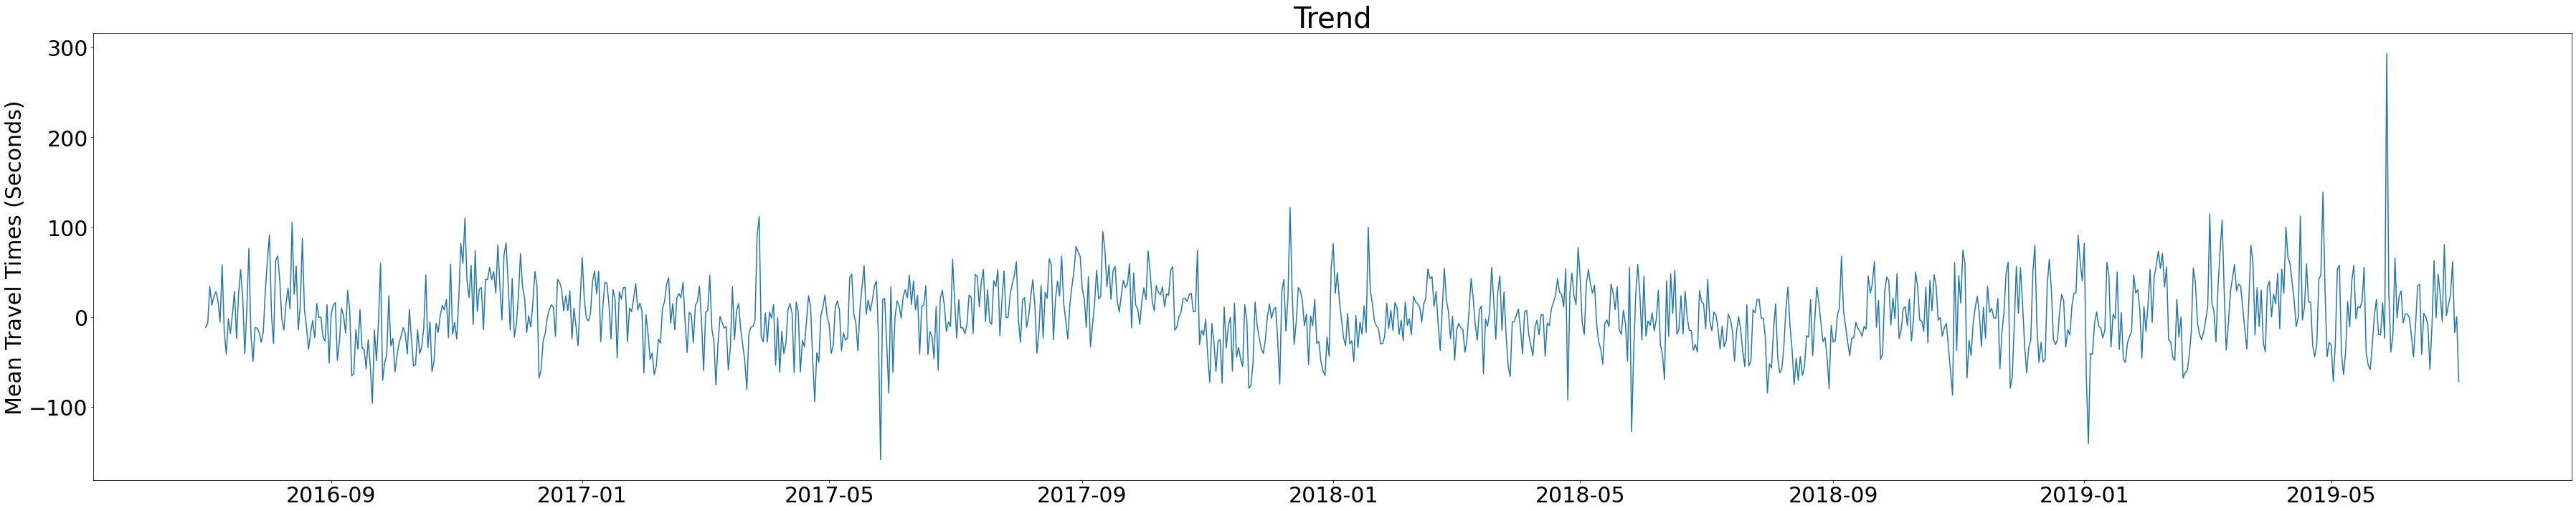

In [55]:
# Plotting trend, seasonality and residuals
decomposition = seasonal_decompose(y, model='additive', period=365)
trend    = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig, ax1 = plt.subplots(1, figsize=(50,10))
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

ax1.plot(y.index.unique(), residual)
ax1.set_title("Trend", fontsize=40)
ax1.set_ylabel("Mean Travel Times (Seconds)", fontsize=30)

# ax2.plot(y.index.unique(), seasonal)
# ax2.set_title("Seasonal", fontsize=40)

# ax3.plot(y.index.unique(), residual)
# ax3.set_title("Residual", fontsize=40)

fig.tight_layout()
plt.show()